In [1]:
import tqdm
import pandas as pd
import numpy as np
import neurokit2 as nk
import mne
from mne_icalabel import label_components
mne.set_log_level('WARNING')
from scipy.integrate import simpson # composite Simpson's rule

import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'''\usepackage{libertine}\usepackage{fontawesome5}\usepackage[dvipsnames]{xcolor}'''
plt.rcParams['ps.usedistiller'] = 'xpdf'
import seaborn as sns
sns.set_theme(style='ticks')

import warnings
warnings.filterwarnings('ignore')

In [2]:
chan_names = ['Fz', 'P3', 'Pz', 'P4', 'PO7', 'Oz', 'PO8']
chan_maps = {
    'Value0': 'Fz',
    'Value1': 'P3',
    'Value2': 'Pz',
    'Value3': 'P4',
    'Value4': 'PO7',
    'Value5': 'Oz',
    'Value6': 'PO8',
}
picks_alpha = ['P3', 'Pz', 'P4']
picks_theta = ['Fz', 'Pz']
picks_beta = ['Fz', 'Pz']

In [3]:
def get_event_intervals(dfAdaptation) -> list:
    intervals = []
    workloads = []
    currentTime = 0
    currentDirection = 'less'
    currentWorkload = 'low'
    for idx, row in dfAdaptation.iterrows():
        if idx == 0:
            currentTime = row['Time']
            currentDirection = row['Direction']
            continue
        if currentDirection == row['Direction']:
            currentTime = row['Time']
            currentDirection = row['Direction']
        if currentDirection != row['Direction']:
            intervals.append((currentTime, row['Time']))
            currentTime = row['Time']
            oldDirection = currentDirection
            currentDirection = row['Direction']
            if oldDirection == 'less' and currentDirection == 'more':
                currentWorkload = 'low'
            elif oldDirection == 'more' and currentDirection == 'less':
                currentWorkload = 'high'
            workloads.append(currentWorkload)
    return intervals, workloads

def load_eeg(pid):
    dfEEG = pd.read_csv(f"./data/ID{pid}-EEG.csv")
    dfState = pd.read_csv(f"./data/ID{pid}-state.csv")
    dfAdaptation = pd.read_csv(f"./data/ID{pid}-adaptation.csv")
    dfEEG.rename(columns=chan_maps, inplace=True)
    dfEEG.drop("TimeLsl", axis =1, inplace=True)
    dfEEG['BlockNumber'] = -1
    intervals, workloads = get_event_intervals(dfAdaptation)

    for idx, interval in enumerate(intervals):
        dfEEG.loc[(dfEEG['Time'] >= interval[0]) & (dfEEG['Time'] <= interval[1]), 'workload'] = workloads[idx]
        dfEEG.loc[(dfEEG['Time'] >= interval[0]) & (dfEEG['Time'] <= interval[1]), 'interval_id'] = idx
    dfEEG = dfEEG[dfEEG['workload'].notna()]

    dfEEG.loc[dfEEG[(dfEEG.Time > dfState['Time'][0]) & (dfEEG.Time < dfState['Time'][0+1])].index, 'BlockNumber']   = dfState['BlockNumber'][0]
    dfEEG.loc[dfEEG[(dfEEG.Time > dfState['Time'][2]) & (dfEEG.Time < dfState['Time'][2+1])].index, 'BlockNumber']   = dfState['BlockNumber'][2]
    dfEEG.loc[dfEEG[(dfEEG.Time > dfState['Time'][4]) & (dfEEG.Time < dfState['Time'][4+1])].index, 'BlockNumber']   = dfState['BlockNumber'][4]
    dfEEG.loc[dfEEG[(dfEEG.Time > dfState['Time'][6]) & (dfEEG.Time < dfState['Time'][6+1])].index, 'BlockNumber']   = dfState['BlockNumber'][6]
    dfEEG.loc[dfEEG[(dfEEG.Time > dfState['Time'][8]) & (dfEEG.Time < dfState['Time'][8+1])].index, 'BlockNumber']  = dfState['BlockNumber'][8]
    dfEEG.loc[dfEEG[(dfEEG.Time > dfState['Time'][10]) & (dfEEG.Time < dfState['Time'][10+1])].index, 'BlockNumber'] = dfState['BlockNumber'][10]
    dfEEG.loc[dfEEG[(dfEEG.Time > dfState['Time'][12]) & (dfEEG.Time < dfState['Time'][12+1])].index, 'BlockNumber'] = dfState['BlockNumber'][12]

    dfAll = dfEEG.copy()
    dfAll = dfAll.drop(dfAll[dfAll.BlockNumber < 0].index)
    dfAll = dfAll.dropna()
    dfAll = dfAll.sort_values(by="Time")
    return dfAll

In [4]:
def compute_eeg_feature(group, freqs_range):
    picks = mne.pick_types(group.info, meg=False, eeg=True, eog=False, stim=False)
    psds, freqs = mne.time_frequency.psd_welch(group, proj=False, picks=picks, n_jobs=2, n_per_seg=50, n_overlap=5, n_fft=300)
    idx = np.logical_and(freqs >= freqs_range[0], freqs <= freqs_range[1])
    psds_mean = psds.mean(0)
    freq_res = freqs[1] - freqs[0]
    return simpson(np.log(psds_mean[idx]), dx=freq_res)

def eeg_analysis(df_block, pid):
    info = mne.create_info(ch_names=chan_names, sfreq=250, ch_types='eeg')
    info.set_montage('standard_1020')
    raw = mne.io.RawArray(df_block[chan_names].values.T, info)
    raw_filter = raw.filter(l_freq=1, h_freq=70, fir_design='firwin2')
    raw_filter_notch = raw_filter.notch_filter([50, 100], picks=chan_names, fir_design='firwin')
    raw_filter_notch_ref = raw_filter_notch.set_eeg_reference('average', projection=True)

    ica = mne.preprocessing.ICA(n_components=len(chan_names), random_state=42, max_iter='auto')
    ica.fit(raw_filter_notch_ref)

    ic_labels = label_components(raw_filter_notch_ref, ica, method="iclabel")

    labels = ic_labels["labels"]
    exclude_idx = [idx for idx, label in enumerate(labels) if label not in ["brain", "other"]]

    reconst_raw = raw_filter_notch_ref.copy()
    ica.apply(reconst_raw, exclude=exclude_idx)
    raw_filter_notch_ref_ica = reconst_raw.copy()

    alpha = compute_eeg_feature(raw_filter_notch_ref_ica.copy().pick_channels(picks_alpha), (8, 12))
    theta = compute_eeg_feature(raw_filter_notch_ref_ica.copy().pick_channels(picks_theta), (4, 8))
    beta  = compute_eeg_feature(raw_filter_notch_ref_ica.copy().pick_channels(picks_beta), (12, 25))
    return pid, len(exclude_idx), alpha, theta, beta, raw_filter_notch_ref_ica

In [5]:
pid_valid = list(range(1, 24))
df_all = {}

for pid in tqdm.tqdm(pid_valid):
    if pid == 4 or pid == 8 or pid == 10 or pid == 15 or pid == 16 or pid == 17 or pid == 21:
        continue
    df = load_eeg(pid)
    df_all[pid] = df

100%|██████████| 23/23 [00:19<00:00,  1.17it/s]


In [6]:
df = pd.DataFrame()
for pid in tqdm.tqdm(pid_valid):
    if pid == 4 or pid == 8 or pid == 10 or pid == 15 or pid == 16 or pid == 17 or pid == 21:
        continue
    df_current = df_all[pid]
    for interval_id in df_current.interval_id.unique():
        df_event = df_all[pid][df_all[pid].interval_id == interval_id]
        if len(df_event) < 1000: # the data is too short to compute ica
            continue

        pid, n_ica, alpha, theta, beta, _ = eeg_analysis(df_event, pid)
        workload = df_event['workload'].values[0]
        df = df.append({
            'pid': pid,
            'n_ica': n_ica,
            'interval': interval_id,
            'block_number': df_event['BlockNumber'].values[0],
            'workload': workload,
            'alpha': alpha,
            'theta': theta,
            'beta': beta,
        }, ignore_index=True)

100%|██████████| 23/23 [06:50<00:00, 17.83s/it]


In [7]:
df['alpha_theta_ratio'] = df['alpha'] / df['theta']
df['beta_theta_ratio'] = df['beta'] / df['theta']
df = df[(df.block_number == 6) | (df.block_number == 7)]
df.to_csv('processed/eeg.csv')

df['alpha_log'] = np.log(df['alpha'])
df['theta_log'] = np.log(df['theta'])
df['beta_log'] = np.log(df['beta'])

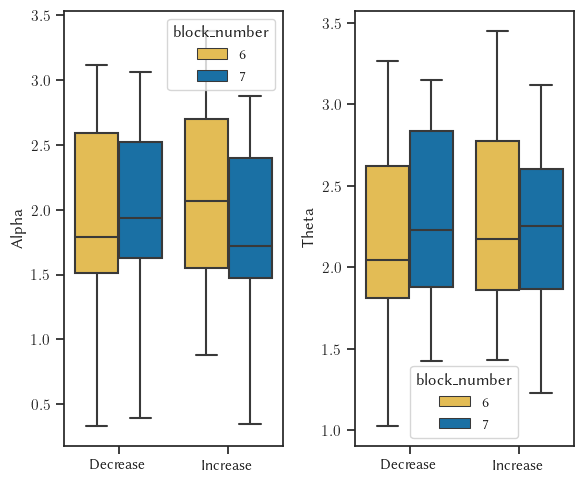

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(6, 5))
colors = list({'yellow' : '#FBC63D', 'blue': '#0376BB'}.values())
sns.boxplot(x='workload', y='alpha_log', data=df, ax=axes[0], hue='block_number', palette=colors, showfliers=False)
sns.boxplot(x='workload', y='theta_log', data=df, ax=axes[1], hue='block_number', palette=colors, showfliers=False)

axes[0].set_ylabel('Alpha')
axes[1].set_ylabel('Theta')

axes[0].set_xticklabels(['Decrease', 'Increase'])
axes[1].set_xticklabels(['Decrease', 'Increase'])

axes[0].set_xlabel('')
axes[1].set_xlabel('')

plt.tight_layout()
plt.savefig('figures/fig3a.pdf')

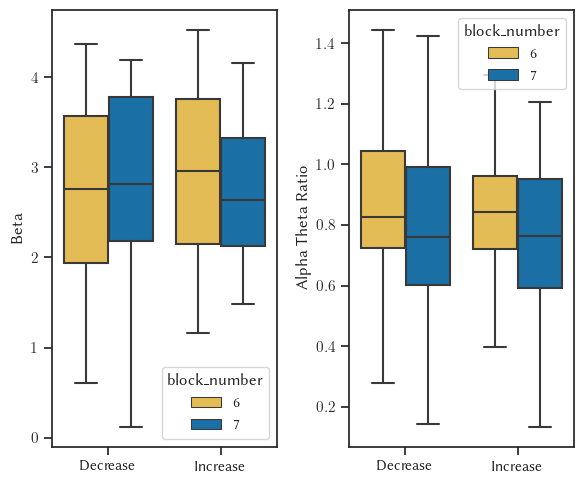

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(6, 5))
colors = list({'yellow' : '#FBC63D', 'blue': '#0376BB'}.values())
sns.boxplot(x='workload', y='beta_log', data=df, ax=axes[0], hue='block_number', palette=colors, showfliers=False)
sns.boxplot(x='workload', y='alpha_theta_ratio', data=df, ax=axes[1], hue='block_number', palette=colors, showfliers=False)

axes[0].set_ylabel('Beta')
axes[1].set_ylabel('Alpha Theta Ratio')

axes[0].set_xticklabels(['Decrease', 'Increase'])
axes[1].set_xticklabels(['Decrease', 'Increase'])

axes[0].set_xlabel('')
axes[1].set_xlabel('')

plt.tight_layout()
plt.savefig('figures/fig3b.pdf')

In [10]:
df = pd.DataFrame(columns=['pid', 'workload', 'n_ica', 'alpha', 'theta', 'beta'])

# block number: []
increased_raws = {
    1: [],
    6: [],
    7: [],
}
decreased_raws = {
    1: [],
    6: [],
    7: [],
}

for pid in tqdm.tqdm(pid_valid):
    if pid == 4 or pid == 8 or pid == 10 or pid == 15 or pid == 16 or pid == 17 or pid == 21:
        continue
    df_current = df_all[pid]
    for interval_id in df_current.interval_id.unique():
        df_event = df_all[pid][df_all[pid].interval_id == interval_id]
        if len(df_event) < 1000: # the data is too short to compute ica
            continue

        pid, n_ica, alpha, theta, beta, raw = eeg_analysis(df_event, pid)
        workload = df_event['workload'].values[0]
        block_number = df_event['BlockNumber'].values[0]
        df = df.append({
            'pid': pid,
            'n_ica': n_ica,
            'block_number': df_event['BlockNumber'].values[0],
            'interval_id': interval_id,
            'workload': workload,
            'alpha': alpha,
            'theta': theta,
            'beta': beta,
        }, ignore_index=True)

        if workload == 'low':
            decreased_raws[block_number].append(raw)
        else:
            increased_raws[block_number].append(raw)

100%|██████████| 23/23 [02:50<00:00,  7.41s/it]


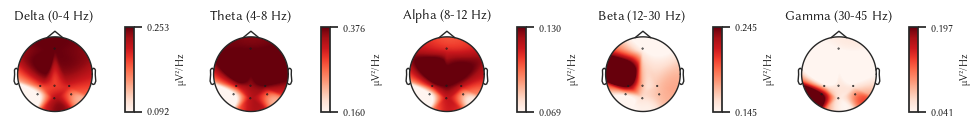

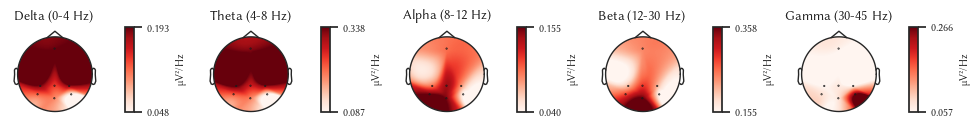

In [11]:
# good adaptation
raw_increase = mne.concatenate_raws(increased_raws[6][2:])
raw_increase.plot_psd_topomap(ch_type='eeg', normalize=True, n_fft=300, n_overlap=5, n_per_seg=50, proj=False, show=False)
plt.savefig('figures/fig2topomap_good_increase.pdf', dpi=300)

# bad adaptation
raw_increase = mne.concatenate_raws(increased_raws[7][2:])
raw_increase.plot_psd_topomap(ch_type='eeg', normalize=True, n_fft=300, n_overlap=5, n_per_seg=50, proj=False, show=False)
plt.savefig('figures/fig2topomap_bad_increase.pdf', dpi=300)

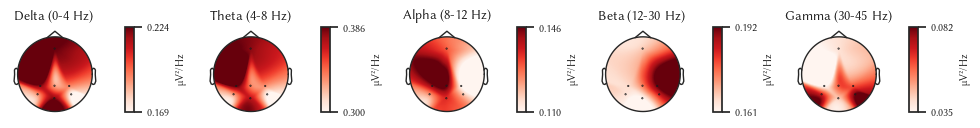

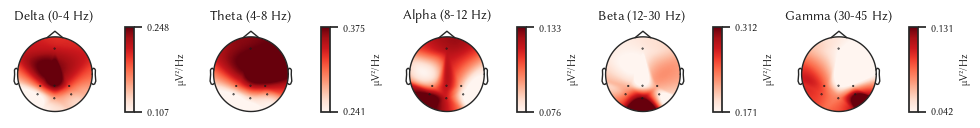

In [12]:
# good adaptation
raw_decrease = mne.concatenate_raws(decreased_raws[6][2:])
raw_decrease.plot_psd_topomap(ch_type='eeg', normalize=True, n_fft=300, n_overlap=5, n_per_seg=50, proj=False, show=False)
plt.savefig('figures/fig2topomap_good_decrease.pdf', dpi=300)

# bad adaptation
raw_decrease = mne.concatenate_raws(decreased_raws[7][2:])
raw_decrease.plot_psd_topomap(ch_type='eeg', normalize=True, n_fft=300, n_overlap=5, n_per_seg=50, proj=False, show=False)
plt.savefig('figures/fig2topomap_bad_decrease.pdf', dpi=300)

In [1]:
import tqdm
import pandas as pd
import numpy as np
import neurokit2 as nk
import mne
from mne_icalabel import label_components
mne.set_log_level('WARNING')
from scipy.integrate import simpson # composite Simpson's rule

import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'''\usepackage{libertine}\usepackage{fontawesome5}\usepackage[dvipsnames]{xcolor}'''
plt.rcParams['ps.usedistiller'] = 'xpdf'
import seaborn as sns
sns.set_theme(style='ticks')

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('processed/eeg.csv')
df['alpha_log'] = np.log(df['alpha'])
df['theta_log'] = np.log(df['theta'])
df['beta_log'] = np.log(df['beta'])

[(0.46988778, 0.58774195, 0.75682037), (0.77636283, 0.46912235, 0.45984473)]


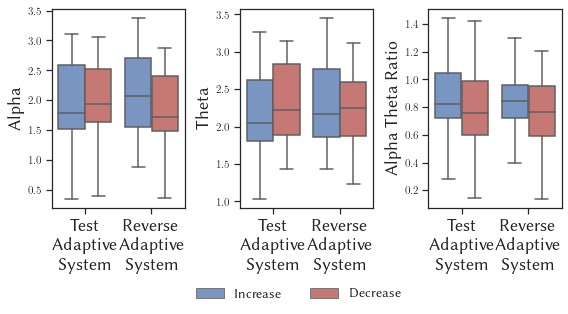

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(8, 4))
colors = sns.color_palette('vlag', n_colors=5)
# colors = sns.color_palette('coolwarm', n_colors=10)
colors = [colors[0], colors[-1]]
print(colors)
# colors = sns.diverging_palette(220, 20, as_cmap=False, n=2)
saturation = 1
# colors = list({'yellow' : '#458a57', 'blue': '#ab334d'}.values())
sns.boxplot(x='workload', y='alpha_log', data=df, ax=axes[0], hue='block_number', palette=colors, showfliers=False, saturation=saturation)
sns.boxplot(x='workload', y='theta_log', data=df, ax=axes[1], hue='block_number', palette=colors, showfliers=False, saturation=saturation)
sns.boxplot(x='workload', y='alpha_theta_ratio', data=df, ax=axes[2], hue='block_number', palette=colors, showfliers=False, saturation=saturation)

axes[0].set_ylabel('Alpha', fontsize=18)
axes[1].set_ylabel('Theta', fontsize=18)
axes[2].set_ylabel('Alpha Theta Ratio', fontsize=18)

axes[0].set_xticklabels(['Test\nAdaptive\nSystem', 'Reverse\nAdaptive\nSystem'], fontsize=18)
axes[1].set_xticklabels(['Test\nAdaptive\nSystem', 'Reverse\nAdaptive\nSystem'], fontsize=18)
axes[2].set_xticklabels(['Test\nAdaptive\nSystem', 'Reverse\nAdaptive\nSystem'], fontsize=18)

axes[0].set_xlabel('')
axes[1].set_xlabel('')
axes[2].set_xlabel('')

axes[0].legend().remove()
axes[1].legend().remove()
axes[2].legend().remove()

# axes[1].set_title('Stream Adaptation')

# create legend
handles, _ = axes[0].get_legend_handles_labels()
fig.legend(handles, ['Increase', 'Decrease'], loc='upper center', ncol=2, bbox_to_anchor=(0.525, 0.03), frameon=False, fontsize=14)

plt.tight_layout()
plt.savefig('figures/fig5.pdf', bbox_inches='tight')